In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# OS Features
import os

# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Processing results
import json

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Modeling
from sklearn.linear_model import LinearRegression

# Preprocessing - Data standardization
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [4]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "204",
    "Plant": "F",
    "Features": "Chemical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [125]:
df = pd.read_csv("../../../../../data/processed/204/f.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we use all available features

In [126]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "Blaine",
        "#200",
        "#325",
        "Final setting time",
        "Initial setting time",
        "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

# 1. Linear Regression

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [127]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

<b>Dataset shape:</b> (594, 38)<br>
<b>Repeats:</b>10<br>
<b>Splits:</b>10<br>
    1. 10 folds of 59 samples each
    2. 90% train (535 samples each fold)
    3. 10% test (59 samples each fold)
<b>Total:</b> 100 models<br>

In [128]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.939 (0.035)
MAE: -1.400 (0.013)
MAPE: -0.033 (0.000)
R2: 0.922 (0.003)


******
[TEST]
******
RMSE: -1.969 (0.153)
MAE: -1.410 (0.040)
MAPE: -0.033 (0.001)
R2: 0.919 (0.013)




<IPython.core.display.Javascript object>

In [129]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [130]:
for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    fold = f"_FOLD_{idx + 1}"
    df_pred["CS28_PRED" + fold] = np.nan
    df_pred["SET" + fold] = ""

    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED" + fold] = results.copy()
    df_pred.loc[index_train, "SET" + fold] = "TRAIN"
    df_pred.loc[index_test, "SET" + fold] = "TEST"

df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()

<IPython.core.display.Javascript object>

In [131]:
df_pred

,DATE,CS28,CS28_PRED_FOLD_1,SET_FOLD_1,CS28_PRED_FOLD_2,SET_FOLD_2,CS28_PRED_FOLD_3,SET_FOLD_3,CS28_PRED_FOLD_4,SET_FOLD_4,...,SET_FOLD_11,CS28_PRED_FOLD_12,SET_FOLD_12,CS28_PRED_FOLD_13,SET_FOLD_13,CS28_PRED_FOLD_14,SET_FOLD_14,CS28_PRED_FOLD_15,SET_FOLD_15,CEMENT_TYPE
0,2020-01-02,36.3,39.697456,TEST,39.708375,TRAIN,39.613436,TRAIN,39.594554,TRAIN,...,TRAIN,39.717157,TEST,39.659281,TRAIN,39.617682,TRAIN,39.585685,TRAIN,CPII F 32
1,2020-01-04,52.2,49.966207,TRAIN,50.056261,TRAIN,49.961162,TRAIN,49.986780,TEST,...,TRAIN,49.911494,TRAIN,49.972208,TRAIN,50.052748,TRAIN,49.977625,TEST,CPV ARI RS
2,2020-01-04,48.7,50.370249,TEST,50.393587,TRAIN,50.307148,TRAIN,50.335970,TRAIN,...,TRAIN,50.286545,TRAIN,50.393326,TRAIN,50.392738,TRAIN,50.305705,TEST,CPV ARI RS
3,2020-01-05,33.0,36.991007,TRAIN,36.789011,TRAIN,36.978100,TRAIN,36.907477,TRAIN,...,TEST,36.943879,TRAIN,36.925763,TRAIN,36.939681,TRAIN,36.829752,TRAIN,CPIV 32
4,2020-01-05,33.8,36.001563,TRAIN,35.960548,TRAIN,35.924956,TRAIN,35.885915,TEST,...,TEST,36.040039,TRAIN,35.967121,TRAIN,35.884464,TRAIN,35.879709,TRAIN,CPII F 32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2557,2023-06-28,47.6,47.684472,TRAIN,47.640743,TRAIN,47.659992,TRAIN,47.713680,TRAIN,...,TRAIN,47.630904,TRAIN,47.641706,TEST,47.795473,TRAIN,47.682114,TRAIN,CPV ARI RS
2558,2023-06-28,36.9,34.774343,TRAIN,34.748134,TRAIN,34.810389,TEST,34.764458,TRAIN,...,TRAIN,34.799744,TEST,34.732600,TRAIN,34.776790,TRAIN,34.710125,TRAIN,CPIV 32
2559,2023-07-02,49.6,47.134144,TRAIN,47.257362,TRAIN,47.211904,TRAIN,47.176162,TEST,...,TEST,47.193926,TRAIN,47.209190,TRAIN,47.209256,TRAIN,47.182970,TRAIN,CPV ARI
2560,2023-07-02,36.5,33.625709,TRAIN,33.670874,TRAIN,33.621634,TRAIN,33.552825,TEST,...,TRAIN,33.729573,TRAIN,33.594759,TEST,33.554271,TRAIN,33.565987,TRAIN,CPII F 32


<IPython.core.display.Javascript object>

In [133]:
df_pred.isna().sum()

DATE                 0
CS28                 0
CS28_PRED_FOLD_1     0
SET_FOLD_1           0
CS28_PRED_FOLD_2     0
SET_FOLD_2           0
CS28_PRED_FOLD_3     0
SET_FOLD_3           0
CS28_PRED_FOLD_4     0
SET_FOLD_4           0
CS28_PRED_FOLD_5     0
SET_FOLD_5           0
CS28_PRED_FOLD_6     0
SET_FOLD_6           0
CS28_PRED_FOLD_7     0
SET_FOLD_7           0
CS28_PRED_FOLD_8     0
SET_FOLD_8           0
CS28_PRED_FOLD_9     0
SET_FOLD_9           0
CS28_PRED_FOLD_10    0
SET_FOLD_10          0
CS28_PRED_FOLD_11    0
SET_FOLD_11          0
CS28_PRED_FOLD_12    0
SET_FOLD_12          0
CS28_PRED_FOLD_13    0
SET_FOLD_13          0
CS28_PRED_FOLD_14    0
SET_FOLD_14          0
CS28_PRED_FOLD_15    0
SET_FOLD_15          0
CEMENT_TYPE          0
dtype: int64

<IPython.core.display.Javascript object>

In [134]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562 entries, 0 to 2561
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DATE               2562 non-null   datetime64[ns]
 1   CS28               2562 non-null   float64       
 2   CS28_PRED_FOLD_1   2562 non-null   float64       
 3   SET_FOLD_1         2562 non-null   object        
 4   CS28_PRED_FOLD_2   2562 non-null   float64       
 5   SET_FOLD_2         2562 non-null   object        
 6   CS28_PRED_FOLD_3   2562 non-null   float64       
 7   SET_FOLD_3         2562 non-null   object        
 8   CS28_PRED_FOLD_4   2562 non-null   float64       
 9   SET_FOLD_4         2562 non-null   object        
 10  CS28_PRED_FOLD_5   2562 non-null   float64       
 11  SET_FOLD_5         2562 non-null   object        
 12  CS28_PRED_FOLD_6   2562 non-null   float64       
 13  SET_FOLD_6         2562 non-null   object        
 14  CS28_PRE

<IPython.core.display.Javascript object>

In [135]:
df_pred.to_excel("fab_204_plant_F_KFOLD.xlsx", index=False)

<IPython.core.display.Javascript object>

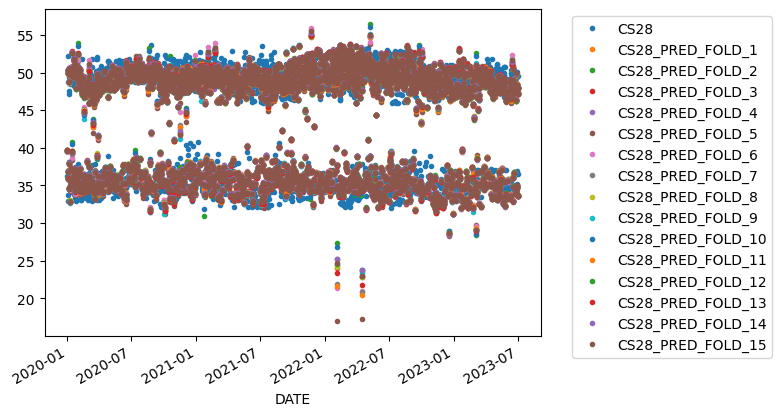

<IPython.core.display.Javascript object>

In [136]:
df_pred.set_index("DATE").plot(style=".")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
r_list = []
for idx, pipeline in enumerate(scores["estimator"]):
    fold = f"_FOLD_{idx + 1}"
    df_filter = df_pred[df_pred["SET" + fold] == "TEST"]
    r = r2_score(df_filter["CS28"], df_filter["CS28_PRED" + fold])
    print(r)
    r_list.append(r)

In [138]:
np.mean(r_list)

0.9194174112686567

<IPython.core.display.Javascript object>

In [161]:
df_geral = pd.concat([df_pred[["CS28"]].copy()] * 15).reset_index(drop=True)
sets = []
preds = []

for idx, pipeline in enumerate(scores["estimator"]):
    fold = f"_FOLD_{idx + 1}"
    sets.append(df_pred["SET" + fold].copy())
    preds.append(df_pred["CS28_PRED" + fold].copy())

df_geral["SET"] = pd.concat(sets).reset_index(drop=True)
df_geral["CS28_PRED"] = pd.concat(preds).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [163]:
df_filter = df_geral[df_geral["SET"] == "TEST"]
r2_score(df_filter["CS28"], df_filter["CS28_PRED"])

0.9195227095304191

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (594, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 118 samples
    2. 50% train (59 samples each fold)
    3. 50% test (59 samples each fold)
<b>Total:</b> 5 models<br>

In [164]:
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.771 (0.156)
MAE: -1.271 (0.150)
MAPE: -0.030 (0.003)
R2: 0.935 (0.010)


******
[TEST]
******
RMSE: -1.998 (0.485)
MAE: -1.518 (0.290)
MAPE: -0.035 (0.007)
R2: 0.910 (0.044)




<IPython.core.display.Javascript object>

In [165]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [166]:
for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [167]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,2020-01-02,36.3,39.297072,TRAIN,CPII F 32
1,2020-01-04,52.2,50.466946,TRAIN,CPV ARI RS
2,2020-01-04,48.7,49.921702,TRAIN,CPV ARI RS
3,2020-01-05,33.0,36.163445,TRAIN,CPIV 32
4,2020-01-05,33.8,35.378976,TRAIN,CPII F 32
...,...,...,...,...,...
2555,2023-06-28,48.5,48.246005,TEST,CPV ARI RS
2556,2023-06-28,36.5,35.652174,TEST,CPII F 32
2557,2023-06-28,47.6,48.246414,TEST,CPV ARI RS
2558,2023-06-28,36.9,35.932740,TEST,CPIV 32


<IPython.core.display.Javascript object>

In [170]:
df_pred.to_excel("fab_204_plant_F_BLOCKING.xlsx", index=False)

<IPython.core.display.Javascript object>

In [171]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2560 entries, 0 to 2559
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE         2560 non-null   datetime64[ns]
 1   CS28         2560 non-null   float64       
 2   CS28_PRED    2560 non-null   float64       
 3   SET          2560 non-null   object        
 4   CEMENT_TYPE  2560 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 120.0+ KB


<IPython.core.display.Javascript object>

In [172]:
df_filter = df_pred[df_pred["SET"] == "TEST"]
r2_score(df_filter["CS28"], df_filter["CS28_PRED"])

0.9092997290895463

<IPython.core.display.Javascript object>

In [173]:
preds = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    preds.append(df_pred.loc[index_test].copy())

scrs = []
for df_filter in preds:
    r = r2_score(df_filter["CS28"], df_filter["CS28_PRED"])
    scrs.append(r)

<IPython.core.display.Javascript object>

In [174]:
np.mean(scrs)

0.9099117484862482

<IPython.core.display.Javascript object>

In [175]:
for r in scrs:
    print(r)

0.9327982875998237
0.9231012306185428
0.9153350298502175
0.8252268827425364
0.9530973116201208


<IPython.core.display.Javascript object>

In [176]:
df_copy2 = df.copy()

<IPython.core.display.Javascript object>

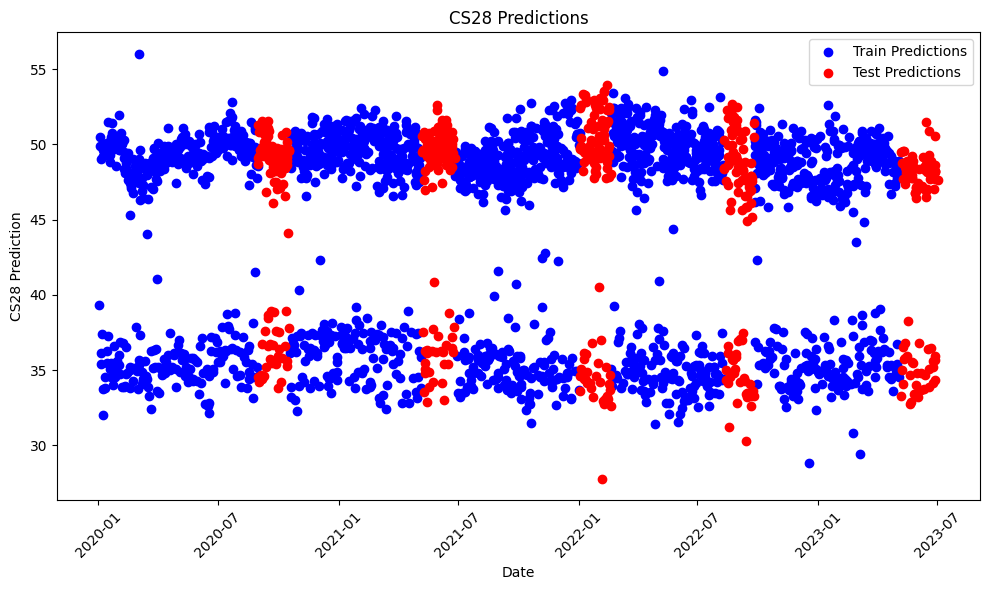

<IPython.core.display.Javascript object>

In [181]:
import pandas as pd
import matplotlib.pyplot as plt


df = df_pred.drop(["CEMENT_TYPE"], axis=1).reset_index(drop=True).copy()

# Convert 'DATE' column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Separate train and test sets
train_data = df[df['SET'] == 'TRAIN']
test_data = df[df['SET'] == 'TEST']

# Plotting
plt.figure(figsize=(10, 6))

plt.scatter(train_data['DATE'], train_data['CS28_PRED'], color='blue', label='Train Predictions')
plt.scatter(test_data['DATE'], test_data['CS28_PRED'], color='red', label='Test Predictions')

# plt.scatter(df['DATE'], df['CS28'], color='green', label='Actual')

plt.xlabel('Date')
plt.ylabel('CS28 Prediction')
plt.title('CS28 Predictions')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


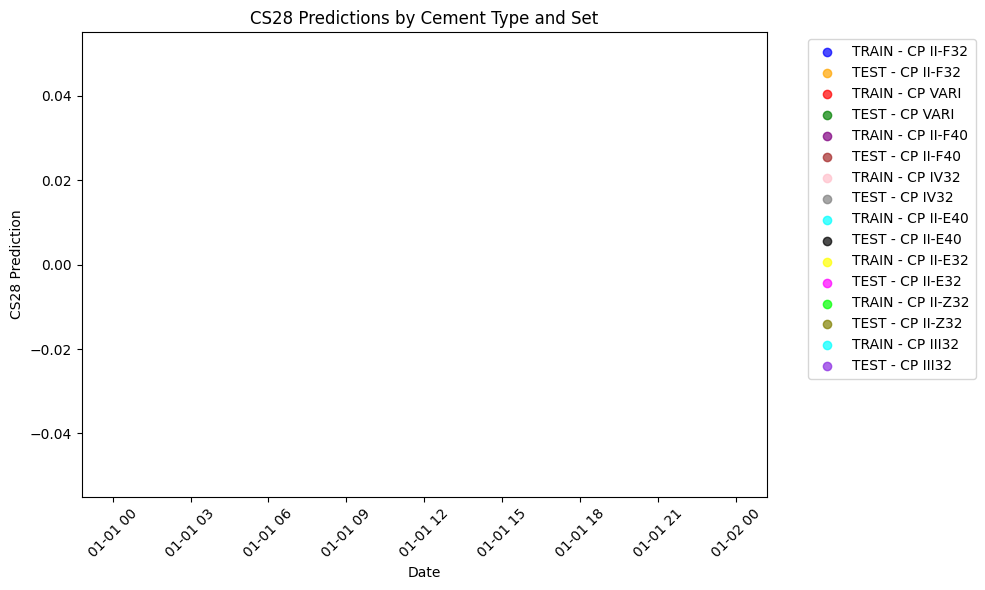

<IPython.core.display.Javascript object>

In [180]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have your DataFrame df
df = df_pred.iloc[1:].reset_index(drop=True).copy()

# Get unique cement types
cement_types = ['CP II-F32', 'CP VARI', 'CP II-F40', 'CP IV32', 'CP II-E40', 'CP II-E32', 'CP II-Z32', 'CP III32']

# Define colors for train and test sets for each cement type
cement_colors = {
    'CP II-F32': {'TRAIN': 'blue', 'TEST': 'orange'},
    'CP VARI': {'TRAIN': 'red', 'TEST': 'green'},
    'CP II-F40': {'TRAIN': 'purple', 'TEST': 'brown'},
    'CP IV32': {'TRAIN': 'pink', 'TEST': 'gray'},
    'CP II-E40': {'TRAIN': 'cyan', 'TEST': 'black'},
    'CP II-E32': {'TRAIN': 'yellow', 'TEST': 'magenta'},
    'CP II-Z32': {'TRAIN': 'lime', 'TEST': 'olive'},
    'CP III32': {'TRAIN': 'cyan', 'TEST': 'blueviolet'}
}

# Plotting
plt.figure(figsize=(10, 6))

# Plotting predictions for each cement type and set type
for cement_type in cement_types:
    for set_type in ['TRAIN', 'TEST']:
        set_cement_data = df[(df['CEMENT_TYPE'] == cement_type) & (df['SET'] == set_type)]
        plt.scatter(set_cement_data['DATE'], set_cement_data['CS28_PRED'], label=f'{set_type} - {cement_type}', color=cement_colors[cement_type][set_type], alpha=0.7)

plt.xlabel('Date')
plt.ylabel('CS28 Prediction')
plt.title('CS28 Predictions by Cement Type and Set')
plt.xticks(rotation=45)

# Place legend outside the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## 1.3. Time Series Split Cross Validation

The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) in the i th split, with a test set of size n_samples//(n_splits + 1) by default, where n_samples is the number of samples.


<b>Dataset shape:</b> (594, 38)<br>
<b>Splits:</b>10<br>    
    1. Train: 10 folds of 54, 108, 162, 216, 270, 324, 378, 432, 486 samples each fold
    2. Test: 54 samples each fold
<b>Total:</b> 10 models<br>

In [10]:
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.820 (0.151)
MAE: -1.315 (0.124)
MAPE: -0.031 (0.003)
R2: 0.932 (0.012)


******
[TEST]
******
RMSE: -2.135 (0.315)
MAE: -1.548 (0.172)
MAPE: -0.036 (0.004)
R2: 0.903 (0.028)




<IPython.core.display.Javascript object>

## 1.4. Out of time Split Cross Validation

<b>Dataset shape:</b> (594, 38)<br>
<b>Train size: 80%</b><br>
<b>Test  size: 20%</b>


<b>Splits:</b> 2<br>    
    1. Train: 475
    2. Test: 118
<b>Total:</b> 1 model<br>

In [11]:
test_size = 0.2

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size, random_state=SEED, shuffle=False
)
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)

pipeline.fit(x_train, y_train)

y_train_pred = pipeline.predict(x_train)
y_test_pred = pipeline.predict(x_test)

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Out of time Split"
results_dict_copy["Cross Validation Params"] = '{"Test Size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(
    results_dict_copy, {key: [value] for key, value in scores.items()}
)
results_to_save.append(df_results)

******
[TRAIN]
******
RMSE: 1.993 (0.000)
MAE: 1.441 (0.000)
MAPE: 0.033 (0.000)
R2: 0.919 (0.000)


******
[TEST]
******
RMSE: 1.816 (0.000)
MAE: 1.334 (0.000)
MAPE: 0.032 (0.000)
R2: 0.927 (0.000)




<IPython.core.display.Javascript object>

In [12]:
pd.concat(results_to_save).groupby(
    ["Features", "Model", "Cross Validation", "Cross Validation Params"]
)[["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]].agg(
    ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
).reset_index().rename(
    columns={"<lambda_0>": "std"}
)

Features              Model            Cross Validation  \
                                                             
0  Chemical  Linear Regression  Blocking Time Series Split   
1  Chemical  Linear Regression           Out of time Split   
2  Chemical  Linear Regression              Repeated KFold   
3  Chemical  Linear Regression           Time Series Split   

                            Cross Validation Params RMSE Test            \
                                                         mean       std   
0  {"N_Splits": 5, "Repeats": 1, "train_size": 0.8}  1.998465  0.484797   
1                                {"Test Size": 0.2}  1.816078  0.000000   
2                     {"N_Splits": 5, "Repeats": 3}  1.969420  0.152776   
3           {"N_Splits": 5, "Repeats": 1, "Gap": 0}  2.135229  0.315449   

   MAE Test           MAPE Test             R2 Test            
       mean       std      mean       std      mean       std  
0  1.517878  0.289553  0.035482  0.006823  0.909912  0.044190  
1  1.334122  0.000000  0.031670  0.000000  0.926967  0.000000  
2  1.410058  0.039831  0.032871  0.001115  0.919417  0.012880  
3  1.548382  0.172280  0.036036  0.003653  0.902621  0.028284

<IPython.core.display.Javascript object>

# Saving the results Dataframe

In [13]:
index_to_save = 2

<IPython.core.display.Javascript object>

In [14]:
path = "../../../../../reports/results/local_models/204/f/full/"
filename = f"linear_regression_results_full_{index_to_save}.csv"

pd.concat(results_to_save).to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

## Saving the grouped dataframe

In [15]:
cols_groupby = [
    "Category",
    "Company",
    "Data Shape",
    "Timesteps",
    "Features",
    "Model",
    "Cross Validation",
    "Cross Validation Params",
]

cols_agg = ["RMSE Train", "MAE Train", "MAPE Train", "R2 Train"] + [
    "RMSE Test",
    "MAE Test",
    "MAPE Test",
    "R2 Test",
]

path = "../../../../../reports/results/local_models/204/f/grouped/"
filename = f"linear_regression_results_grouped_{index_to_save}.csv"


df_results_to_save = (
    pd.concat(results_to_save)
    .groupby(cols_groupby, dropna=False)[cols_agg]
    .agg(["mean", lambda series: pd.Series(series.std(ddof=0), name="std")])
    .reset_index()
    .rename(columns={"<lambda_0>": "std"})
)

df_results_to_save.to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

In [16]:
pd.Series(
    pipeline.named_steps["estimator"].coef_,
    df_copy.drop(["Date"], axis=1).columns,
).to_frame(name="Coefficients").sort_values(
    by="Coefficients"
).style.background_gradient(
    axis=None, vmin=1, vmax=5, cmap="Greens"
)

,Coefficients
Loss on Ignition,-2.471971
SiO2,-0.282642
Fe2O3,-0.118890
K2O,0.019808
Na2O,0.066136
MgO,0.140063
Al2O3,0.391064
CaO,1.031876
SO3,4.117608


<IPython.core.display.Javascript object>